

# **Libraries**

In [57]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# **Data**

## Loading Data

In [58]:
train = pd.read_csv("/content/drive/My Drive/RuCode 2020/rucode-fake-job-postings/train_data.csv")
test = pd.read_csv("/content/drive/My Drive/RuCode 2020/rucode-fake-job-postings/test_data.csv")

train.head(3)

,Id,Название,Место,Отдел,Зарплата,Описание компании,Описание вакансии,Требования,Соцпакет,Дистанционно,Вопросы,Тип занятости,Опыт,Образование,Индустрия,Позиция,Фейк
0,10497,"Reporter, Agri Investor","US, ,",KHR,NaN,PEI Media (#URL_4cffe430b8da4c0d7e6074d11e638d...,Seeking savvy business reporter Are you a news...,The successful candidate should have a bachelo...,PEI Media (#URL_4cffe430b8da4c0d7e6074d11e638d...,0,0,Full-time,Associate,Bachelor's Degree,Publishing,Writing/Editing,0
1,8219,Software Engineer,"US, VA, Herndon",Software Engineering,NaN,Roka Security is a boutique security firm that...,Roka Security is looking for Software Engineer...,NaN,NaN,0,0,Full-time,Not Applicable,Unspecified,Computer Software,Engineering,0
2,5342,Structural Engineer,"NL, ZH, Rotterdam",onshore,NaN,NaN,Job tasks:Analyse project specifications on st...,Job requirements:HTS/TU Civil Engineering or M...,NaN,0,1,NaN,NaN,NaN,NaN,NaN,0


## Renaming Data

In [59]:
columns = {   
            'Название': 'job_name',                   # text 7261 unique        Done
            'Место': 'workplace',                     # text 2314 unique        Done
            'Отдел': 'work_dep',                      # classes 953 unique        REMOVE
            'Зарплата': 'salary',                     # classes 650 unique        REMOVE
            'Описание компании': 'comp_desc',         # text 1435 unique        Done
            'Описание вакансии': 'vac_desc',          # text 1435 unique        Done
            'Требования': 'emp_req',                  # text 7485 unique        Done
            'Соцпакет': 'social_package',             # text 4104 unique        Done  "\xa0"
            'Дистанционно': 'remotely',               # classes 2 unique
            'Вопросы': 'questions',                   # classes 2 unique
            'Тип занятости': 'employment_type',       # classes 6 unique
            'Опыт': 'work_exp',                       # classes 8 unique
            'Образование': 'ed',                      # classes 14 unique
            'Индустрия': 'ind',                       # classes 129 unique
            'Позиция': 'pos',                         # classes 38 unique
            'Фейк': 'desired_value'                   # classes 2 unique
        }
train.rename(columns=columns, inplace=True)
test.rename(columns=columns, inplace=True)

In [60]:
train.head()

,Id,job_name,workplace,work_dep,salary,comp_desc,vac_desc,emp_req,social_package,remotely,questions,employment_type,work_exp,ed,ind,pos,desired_value
0,10497,"Reporter, Agri Investor","US, ,",KHR,NaN,PEI Media (#URL_4cffe430b8da4c0d7e6074d11e638d...,Seeking savvy business reporter Are you a news...,The successful candidate should have a bachelo...,PEI Media (#URL_4cffe430b8da4c0d7e6074d11e638d...,0,0,Full-time,Associate,Bachelor's Degree,Publishing,Writing/Editing,0
1,8219,Software Engineer,"US, VA, Herndon",Software Engineering,NaN,Roka Security is a boutique security firm that...,Roka Security is looking for Software Engineer...,NaN,NaN,0,0,Full-time,Not Applicable,Unspecified,Computer Software,Engineering,0
2,5342,Structural Engineer,"NL, ZH, Rotterdam",onshore,NaN,NaN,Job tasks:Analyse project specifications on st...,Job requirements:HTS/TU Civil Engineering or M...,NaN,0,1,NaN,NaN,NaN,NaN,NaN,0
3,1916,Senior Publishing Specialist,"US, ,",NaN,NaN,NaN,The Senior Publishing Specialist will be part ...,Minimum of 3 – 4 years experience in Regulator...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0
4,1811,Sales Representative,"CA, BC, Vancouver",Sales & Marketing,NaN,NaN,BCCC Enterprises provides management consultin...,Key Responsibilities:Contribute to the financi...,How to ApplyThis is an exciting opportunity. ...,0,1,NaN,NaN,NaN,NaN,NaN,0


## Defining cleaning functions

Cleaning up text and spliting into an array


In [61]:
def clean_text(text):
    sents = text

    punct = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~„“«»†*—/\-‘’'

    for i, sent in enumerate(sents):
        sent = str(sent).replace(u'\xa0', u' ')                 # for social_package
        sent = sent.replace(u'&amp', u' ')               
        s = " ".join([w.lower().strip(punct) for w in sent.split()])
        # s = str(sent.lower().strip(punct))
        text[i] = s

In [62]:
def add_index(column, nan = False):
    indexes_list = list(column.unique())
    if nan:
        for i in range(len(column)):
            if str(column[i]).lower() != 'nan':
                column[i] = indexes_list.index(column[i])
    else:
        for i in range(len(column)):
                column[i] = indexes_list.index(column[i])

In [63]:
def clean_data(data):
    data = data.drop(columns=["salary", "work_dep"])
    add_index(data.remotely)
    add_index(data.questions)
    add_index(data.work_exp)
    add_index(data.ed)
    add_index(data.ind)
    add_index(data.pos)
    add_index(data.employment_type)
    clean_text(data.job_name)
    clean_text(data.workplace)
    clean_text(data.comp_desc)
    clean_text(data.vac_desc)
    clean_text(data.emp_req)
    clean_text(data.social_package)
    return data

## Cleaning Data

In [64]:
testId = test.Id

In [65]:
train = clean_data(train)
test = clean_data(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


# **Embedding Layer Creator (func)**

In [66]:
def get_vectorizer(text_list, text_test_list):
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

    maxL1 = len(max(text_list, key=len).split())+1
    maxL2 = len(max(text_test_list, key=len).split())+1
    vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max(maxL1, maxL2))
    text_ds = tf.data.Dataset.from_tensor_slices(text_list).batch(128)
    vectorizer.adapt(text_ds)
    return vectorizer

In [67]:
def get_voc(vectorizer):
    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
    return {"voc": voc, "word_index": word_index}

### Load pre-trained word embeddings

In [68]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [69]:
import os
import pathlib

# path_to_glove_file = "/content/glove.6B.100d.txt"
path_to_glove_file = "/content/drive/My Drive/RuCode 2020/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [70]:
def get_embedding_matrix(params):
    voc = params["voc"]
    word_index = params["word_index"]
    
    num_tokens = len(voc) + 2
    embedding_dim = 100
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return {"em": embedding_matrix, "nt": num_tokens, "ed":embedding_dim}

Load the pre-trained word embeddings matrix into an *Embedding* layer

In [71]:
from tensorflow.keras.layers import Embedding
def get_embedding(params):
    embedding_matrix = params["em"]
    num_tokens = params["nt"]
    embedding_dim = params["ed"]

    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False
    )
    return embedding_layer

# **Making the Embedding Layers**

In [72]:
vec_comp_desc = get_vectorizer(train.comp_desc, test.comp_desc)
vec_emp_req = get_vectorizer(train.emp_req, test.emp_req)
vec_job_name = get_vectorizer(train.job_name, test.job_name)
vec_social_package = get_vectorizer(train.social_package, test.social_package)
vec_vac_desc = get_vectorizer(train.vac_desc, test.vac_desc)
vec_workplace = get_vectorizer(train.workplace, test.workplace)

emb_comp_desc = get_embedding(get_embedding_matrix(get_voc(vec_comp_desc)))
emb_emp_req = get_embedding(get_embedding_matrix(get_voc(vec_emp_req)))
emb_job_name = get_embedding(get_embedding_matrix(get_voc(vec_job_name)))
emb_social_package = get_embedding(get_embedding_matrix(get_voc(vec_social_package)))
emb_vac_desc = get_embedding(get_embedding_matrix(get_voc(vec_vac_desc)))
emb_workplace = get_embedding(get_embedding_matrix(get_voc(vec_workplace)))

Converted 11074 words (6030 misses)
Converted 9627 words (10373 misses)
Converted 3238 words (1006 misses)
Converted 7793 words (9768 misses)
Converted 12340 words (7660 misses)
Converted 1784 words (144 misses)


# **Building the Model**


In [91]:
from tensorflow.keras import layers

def build_part(input, embedding_layer, num):
    embedded_sequences = embedding_layer(input)
    x = layers.Conv1D(128, num, activation="relu")(embedded_sequences)
    x = layers.MaxPooling1D(num)(x)
    x = layers.Conv1D(128, num, activation="relu")(x)
    x = layers.MaxPooling1D(num)(x)
    x = layers.Conv1D(128, num, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation="relu")(x)
    return x

def build_num_part(input):
    x = layers.Dense(20, activation="relu")(input)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation="relu")(x)
    return x

def build_model():
    inputs = [
              keras.Input(shape=(None,), dtype="int64"), 
              keras.Input(shape=(None,), dtype="int64"), 
              keras.Input(shape=(None,), dtype="int64"),
              keras.Input(shape=(None,), dtype="int64"),
              keras.Input(shape=(None,), dtype="int64"),
              keras.Input(shape=(None,), dtype="int64"),
              keras.Input(shape=(8))     #for nums
             ]
    outputs = [
               build_part(inputs[0], emb_comp_desc, 5),
               build_part(inputs[1], emb_emp_req, 5),
               build_part(inputs[2], emb_social_package, 5),
               build_part(inputs[3], emb_vac_desc, 5),
               build_part(inputs[4], emb_workplace, 1),
               build_part(inputs[5], emb_job_name, 2),
               build_num_part(inputs[6]),
              ]
    concat = layers.Concatenate(axis=1)
    x = layers.Dense(10, activation="relu")(concat(outputs))
    x = layers.Dense(10, activation="relu")(x)
    x = layers.Dense(10, activation="relu")(x)
    x = layers.Dense(10, activation="relu")(x)
    x = layers.Dense(10, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    preds = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, preds)
    
    return model

In [92]:
model = build_model()

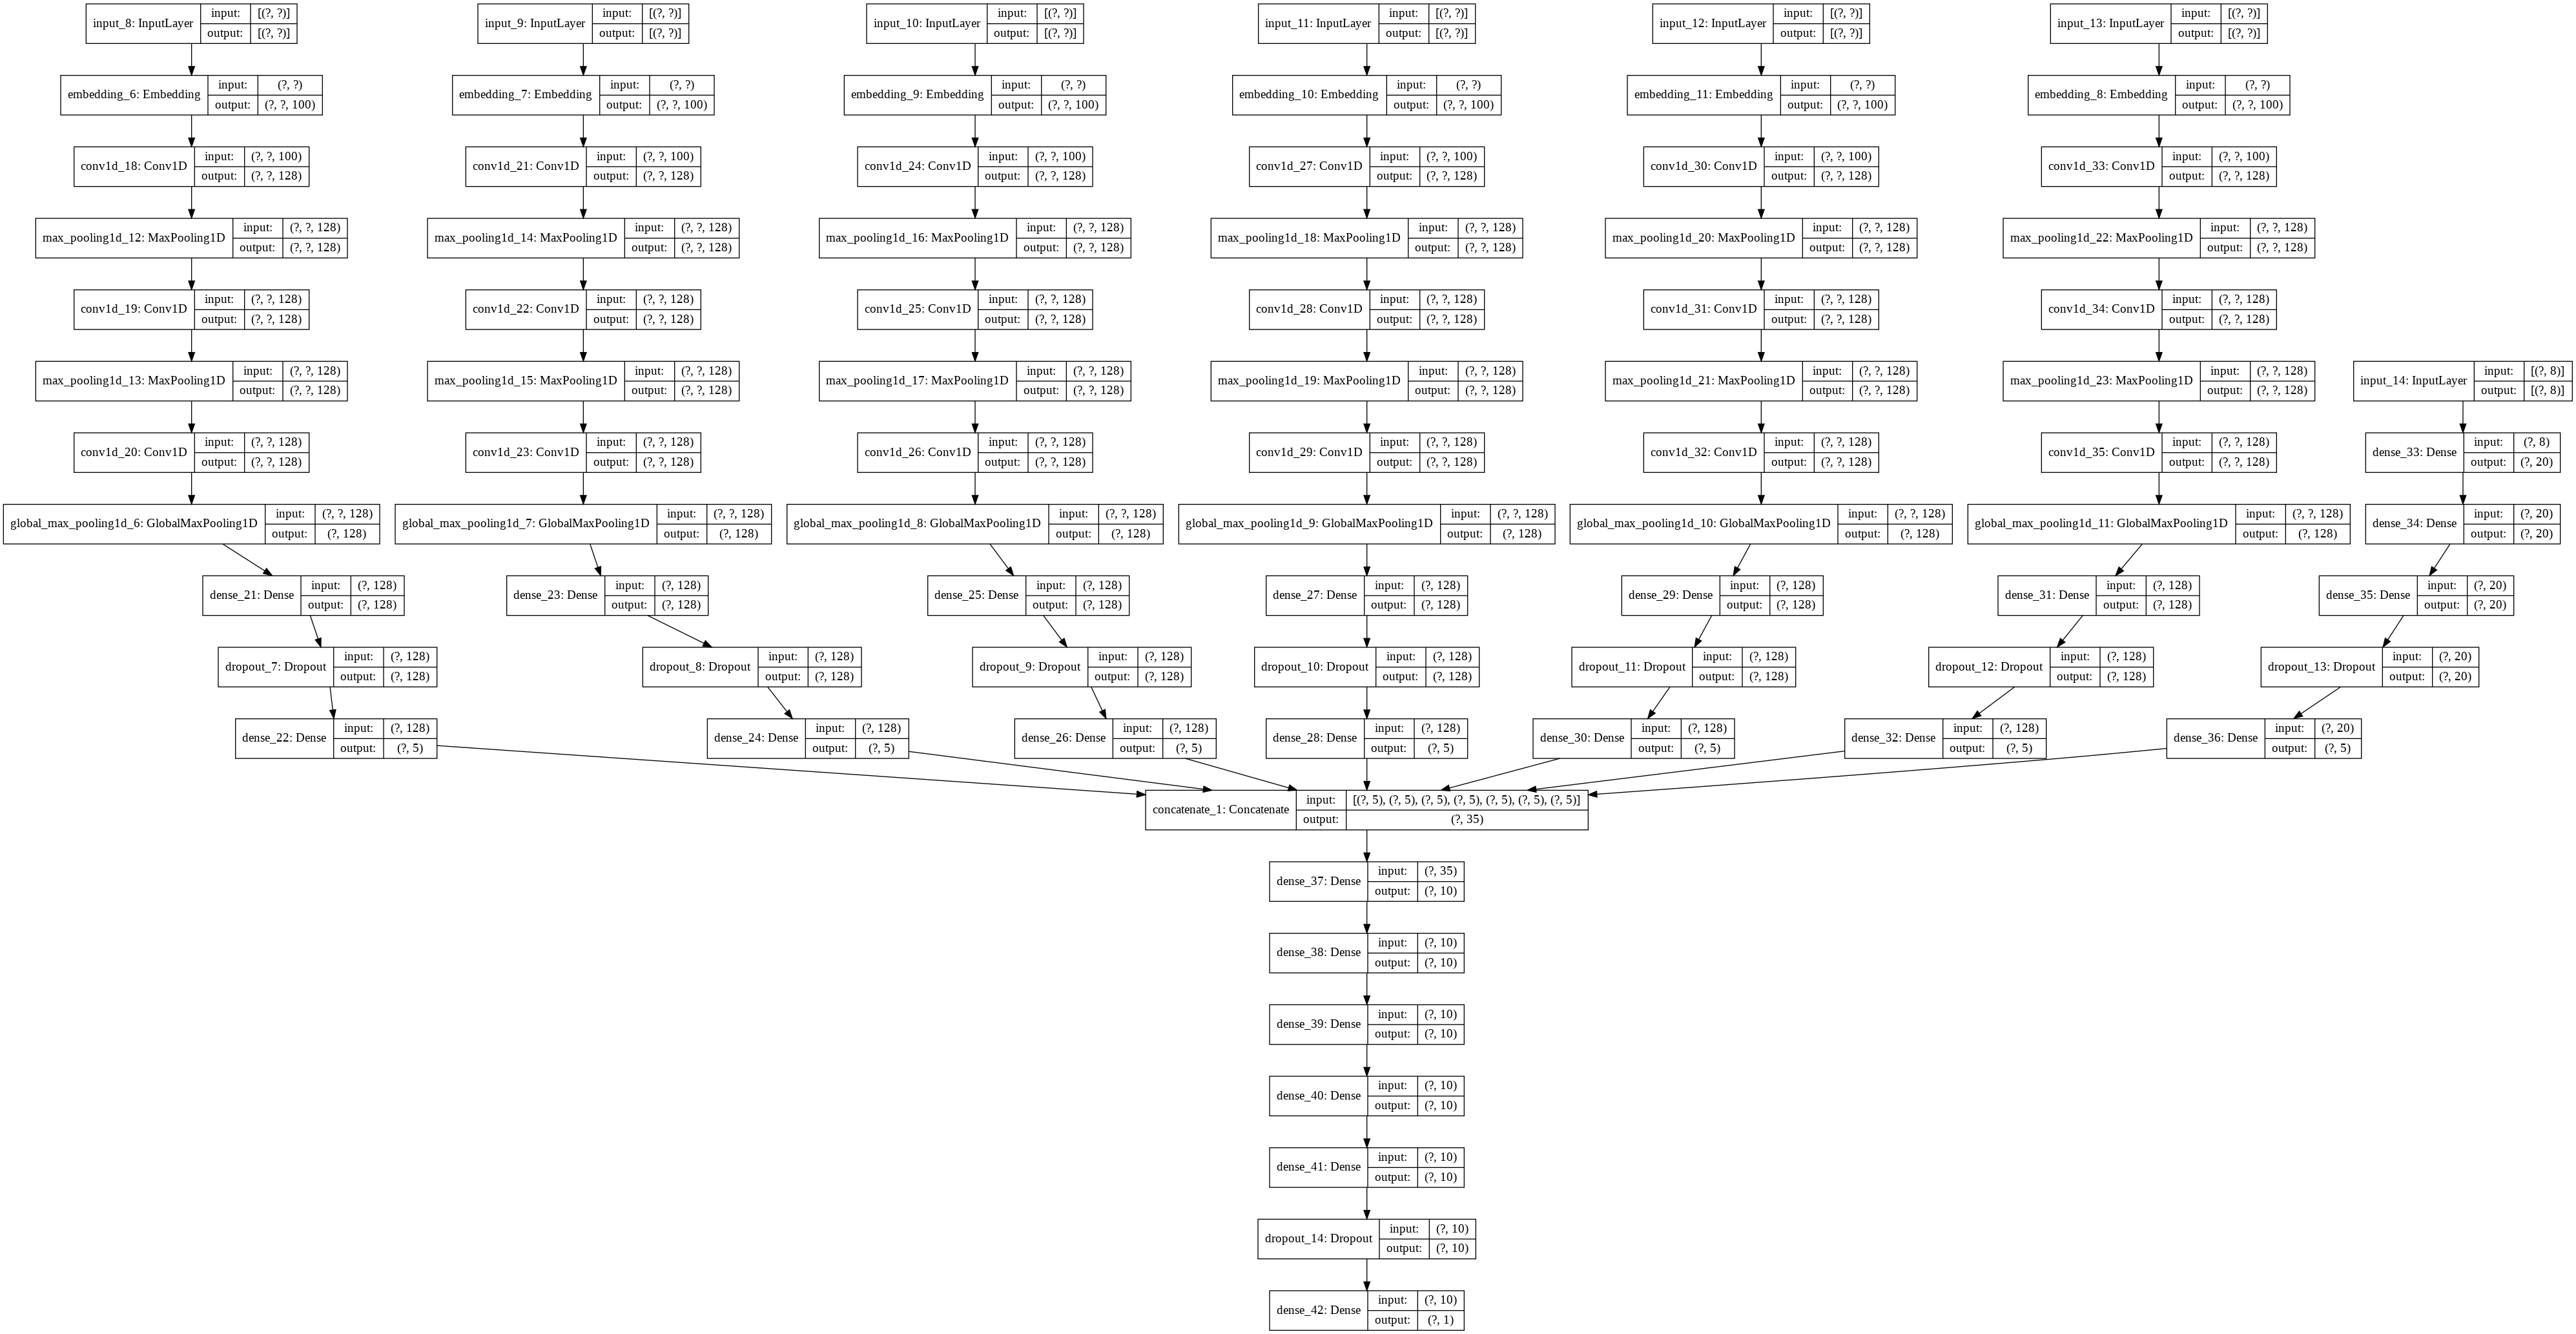

In [93]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Train the Model**

In [94]:
t = np.asarray(train.drop(columns=["comp_desc", "emp_req", "social_package", "vac_desc", "workplace", "job_name", "desired_value"]).to_numpy(), dtype=np.float)
X = [
    vec_comp_desc(np.array([[s] for s in train["comp_desc"]])).numpy(),
    vec_emp_req(np.array([[s] for s in train["emp_req"]])).numpy(),    
    vec_social_package(np.array([[s] for s in train["social_package"]])).numpy(),
    vec_vac_desc(np.array([[s] for s in train["vac_desc"]])).numpy(),
    vec_workplace(np.array([[s] for s in train["workplace"]])).numpy(),
    vec_job_name(np.array([[s] for s in train["job_name"]])).numpy(),
    t
]

Y = train["desired_value"].to_numpy()

Custom loss function incase y_pred is zero

In [95]:
from keras import backend as K

def lossF(yT, yP):
    return tf.keras.losses.binary_crossentropy(yT, yP + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Weigh the imbalanced data

In [96]:
w0 = 2* len(Y[Y == 1])/len(Y)
w1 = 2* len(Y[Y == 0])/len(Y)

In [ ]:
# model.compile(
#     loss = lossF, 
#     optimizer = "rmsprop", 
#     metrics = ["acc", f1_m]
# )

history = model.fit(X, Y, batch_size=128, epochs=10, shuffle=True, class_weight = {0: w0, 1: w1})

Epoch 1/10
84/84 [==============================] - 470s 6s/step - loss: 0.4135 - acc: 0.9471 - f1_m: 0.5588
Epoch 2/10
84/84 [==============================] - 469s 6s/step - loss: 0.0418 - acc: 0.9448 - f1_m: 0.6191
Epoch 3/10
14/84 [====>.........................] - ETA: 6:08 - loss: 0.0331 - acc: 0.9526 - f1_m: 0.6352

In [80]:
path = "/content/drive/My Drive/RuCode 2020/rucode-fake-job-postings/model_wierd_layers"
model.save(path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/RuCode 2020/rucode-fake-job-postings/model_wierd_layers/assets


# **Load Model**

In [ ]:
# model = tf.keras.models.load_model(path, custom_objects={"f1_m": f1_m, "lossF": lossF},compile=False)

# model.compile(
#     loss = lossF, 
#     optimizer = "rmsprop", 
#     metrics = ["acc", f1_m]
# )

# **History**

dict_keys(['loss', 'acc', 'f1_m'])


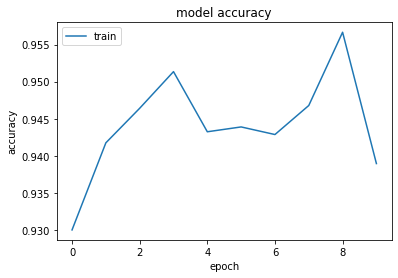

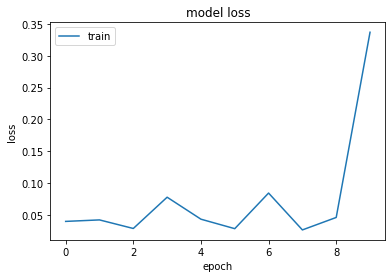

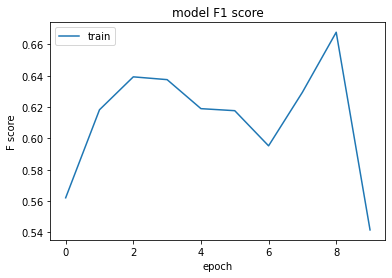

In [104]:
import matplotlib.pyplot as plt

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "F-score"
plt.plot(history.history['f1_m'])
# plt.plot(history.history['val_f1_m'])
plt.title('model F1 score')
plt.ylabel('F score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Making Test CSV**

In [99]:
t_test = np.asarray(test.drop(columns=["comp_desc", "emp_req", "social_package", "vac_desc", "workplace", "job_name"]).to_numpy(), dtype=np.float)
X_test = [
    vec_comp_desc(np.array([[s] for s in test["comp_desc"]])).numpy(),
    vec_emp_req(np.array([[s] for s in test["emp_req"]])).numpy(),    
    vec_social_package(np.array([[s] for s in test["social_package"]])).numpy(),
    vec_vac_desc(np.array([[s] for s in test["vac_desc"]])).numpy(),
    vec_workplace(np.array([[s] for s in test["workplace"]])).numpy(),
    vec_job_name(np.array([[s] for s in test["job_name"]])).numpy(),
    t_test
]

In [84]:
print(X_test[6].shape)
print(X[6].shape)

(7152, 8)
(10728, 8)


In [100]:
res = np.rint(model.predict(X_test))

In [101]:
# f = open("/content/drive/My Drive/RuCode 2020/rucode-fake-job-postings/submission.csv", "a")
f = open("/content/submission.csv", "a")
f.write("Id,Фейк")
for ind, i in enumerate(res, start=0):
    f.write("\n"+str(testId[ind])+","+str(int(i)))
f.close()